# Final Assignment: Predicting User Adoption

## 1. Import Libraries and Load the Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
users_df = pd.read_csv('/Users/manuelramirez/Documents/relax_challenge/takehome_users.csv', encoding='latin-1')
engagement_df = pd.read_csv('/Users/manuelramirez/Documents/relax_challenge/takehome_user_engagement.csv')


## 2. Define Adopted Users

In [16]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Group by user_id
adopted_users = []
for user_id, group in engagement_df.groupby('user_id'):
    dates = group['time_stamp'].sort_values()
    for i in range(len(dates) - 2):
        if (dates.iloc[i + 2] - dates.iloc[i]).days <= 7:
            adopted_users.append(user_id)
            break

adopted_users_set = set(adopted_users)
users_df['adopted'] = users_df['object_id'].apply(lambda x: 1 if x in adopted_users_set else 0)


# 3. Identify Adopted Users
# An adopted user has logged in on 3 separate days within a 7-day period

In [17]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])
adopted_users = []
for user_id, group in engagement_df.groupby('user_id'):
    dates = group['time_stamp'].sort_values()
    for i in range(len(dates) - 2):
        if (dates.iloc[i + 2] - dates.iloc[i]).days <= 7:
            adopted_users.append(user_id)
            break
adopted_users_set = set(adopted_users)
users_df['adopted'] = users_df['object_id'].apply(lambda x: 1 if x in adopted_users_set else 0)


# 4. Feature Engineering
# Convert timestamps

In [20]:
# Convert timestamps
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

# Create numeric features from datetime columns
users_df['account_age_days'] = (pd.Timestamp.now() - users_df['creation_time']).dt.days
users_df['days_since_last_session'] = (pd.Timestamp.now() - users_df['last_session_creation_time']).dt.days

# Create binary feature for whether the user was invited
users_df['invited'] = users_df['invited_by_user_id'].notnull().astype(int)

# Check if 'creation_source' exists before one-hot encoding
if 'creation_source' in users_df.columns:
    users_df = pd.get_dummies(users_df, columns=['creation_source'])
else:
    print("Warning: 'creation_source' column not found for encoding.")

# Drop unnecessary columns for modeling
columns_to_drop = ['name', 'email', 'org_id', 'invited_by_user_id', 'object_id', 'creation_time', 'last_session_creation_time']
users_model_df = users_df.drop(columns=[col for col in columns_to_drop if col in users_df.columns])


## MODELING


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2063
           1       0.93      0.82      0.87       337

    accuracy                           0.97      2400
   macro avg       0.95      0.90      0.93      2400
weighted avg       0.97      0.97      0.97      2400



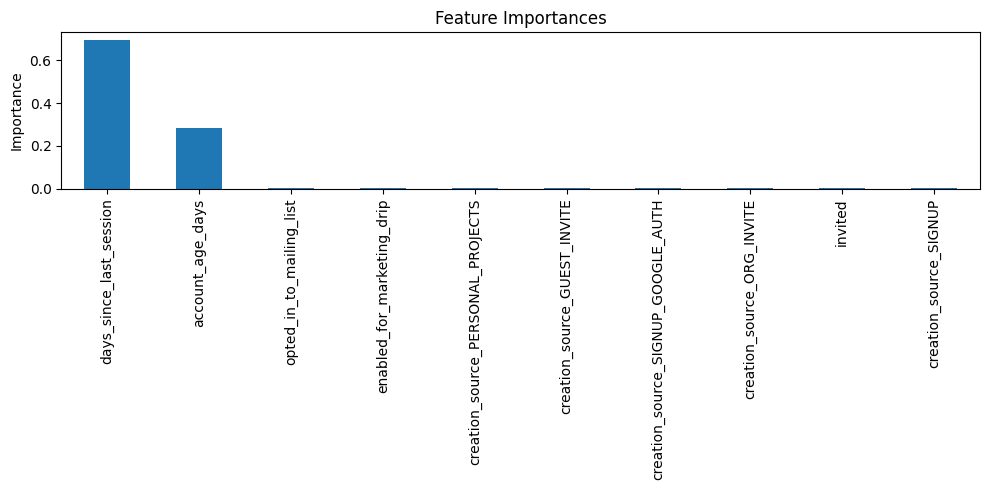

In [21]:
# 5. Prepare Data for Modeling
X = users_model_df.drop('adopted', axis=1)
y = users_model_df['adopted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 7. Evaluate the Model
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 8. Feature Importances
feat_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
feat_imp.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

